In [1]:
import sys
sys.path.append('/mnt/home/mbedell/.local/lib/python3.7/site-packages')

In [2]:
%matplotlib inline

In [3]:
%run notebook_setup.py

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import glob
from tqdm import tqdm
import h5py

### Look at all sectors:

In [5]:
data_dir = '/mnt/ceph/users/mbedell/tess/'
fns = glob.glob(data_dir+'sector*.hdf5')

In [6]:
ts = []
bkgs = []
for fn in tqdm(fns):
    with h5py.File(fn,'r') as f:
        bkgs.append(np.copy(f['median_bkg']))
        ts.append(np.copy(f['time']))

100%|██████████| 6/6 [00:00<00:00,  9.29it/s]


In [7]:
t = np.concatenate(ts)
inds = np.argsort(t)
t = t[inds]
bkg = np.concatenate(bkgs)[inds]

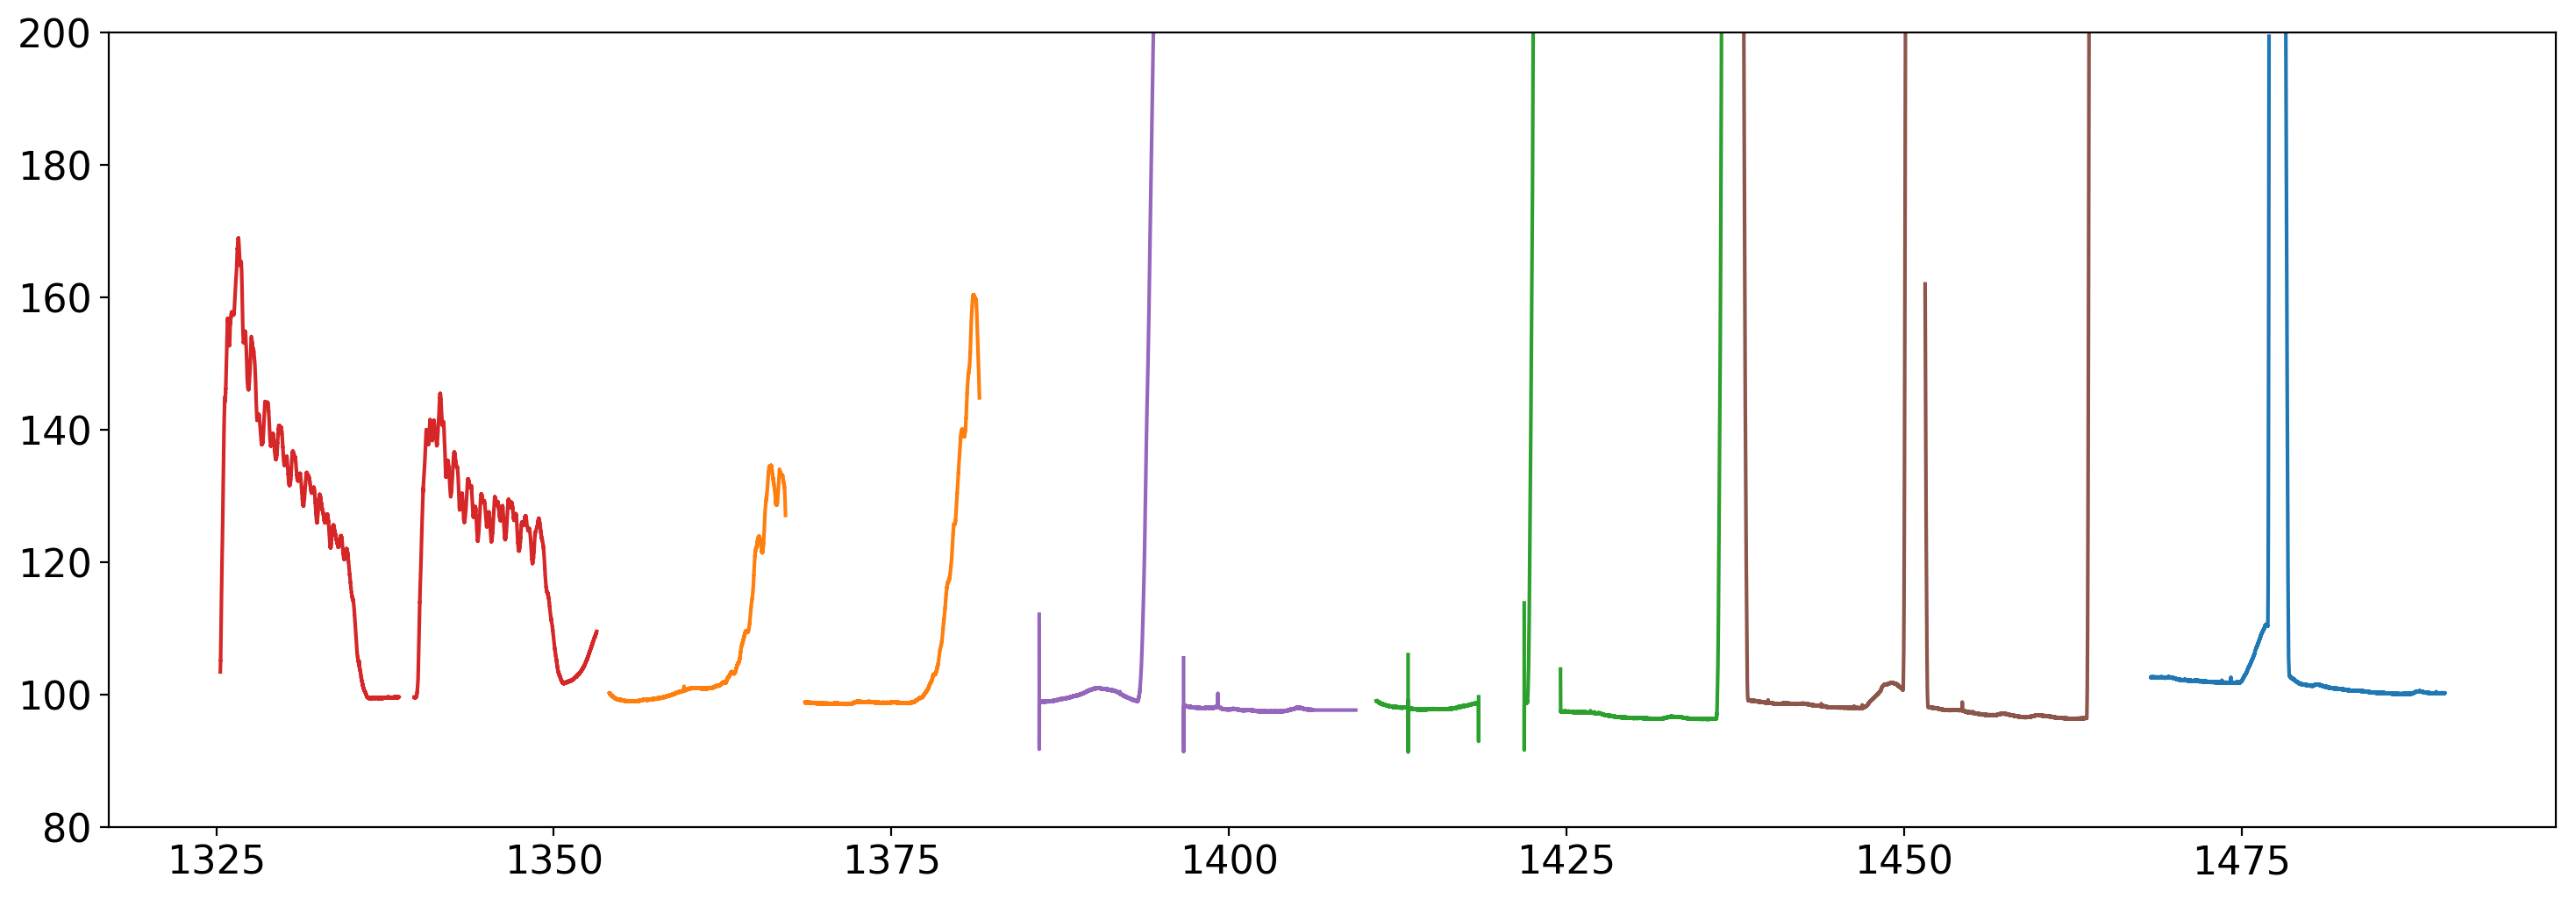

In [8]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
for tt,bb in zip(ts, bkgs):
    ax.plot(tt,bb)
#ax.plot(t,bkg,'k.')
ax.set_ylim([80,200]);

In [9]:
with h5py.File(data_dir+'all_sectors.hdf5', 'w') as f:
    f.create_dataset('time', data=t)
    f.create_dataset('median_bkg', data=bkg)

### single sector only:

In [10]:
sector = 2
with h5py.File(data_dir+'sector{0:02.0f}.hdf5'.format(sector),'r') as f:
    cols = np.copy(f['cols'])
    rows = np.copy(f['rows'])
    ccds = np.copy(f['ccds'])
    cameras = np.copy(f['cameras'])
    bkgs = np.copy(f['bkgs'])
    bkg_errs = np.copy(f['bkg_errs'])
    time = np.copy(f['time'])
    bkg = np.copy(f['median_bkg'])

#### Remove the epochs & stars without data

In [11]:
inds = np.sum(np.isnan(bkgs), axis=0) # for each time, how many stars are NaNs

In [12]:
drop = np.where(inds == max(inds))[0]
bkgs = np.delete(bkgs, drop, axis=1)
bkg_errs = np.delete(bkg_errs, drop, axis=1)
time = np.delete(time, drop)
bkg = np.delete(bkg, drop)

In [13]:
inds = np.sum(np.isnan(bkgs), axis=1) # for each star, how many times are NaNs

In [14]:
drop = np.where(inds == max(inds))[0]
bkgs = np.delete(bkgs, drop, axis=0)
bkg_errs = np.delete(bkg_errs, drop, axis=0)
cols = np.delete(cols, drop)
rows = np.delete(rows, drop)
ccds = np.delete(ccds, drop)
cameras = np.delete(cameras, drop)

### Check out the range of behaviors

In general:

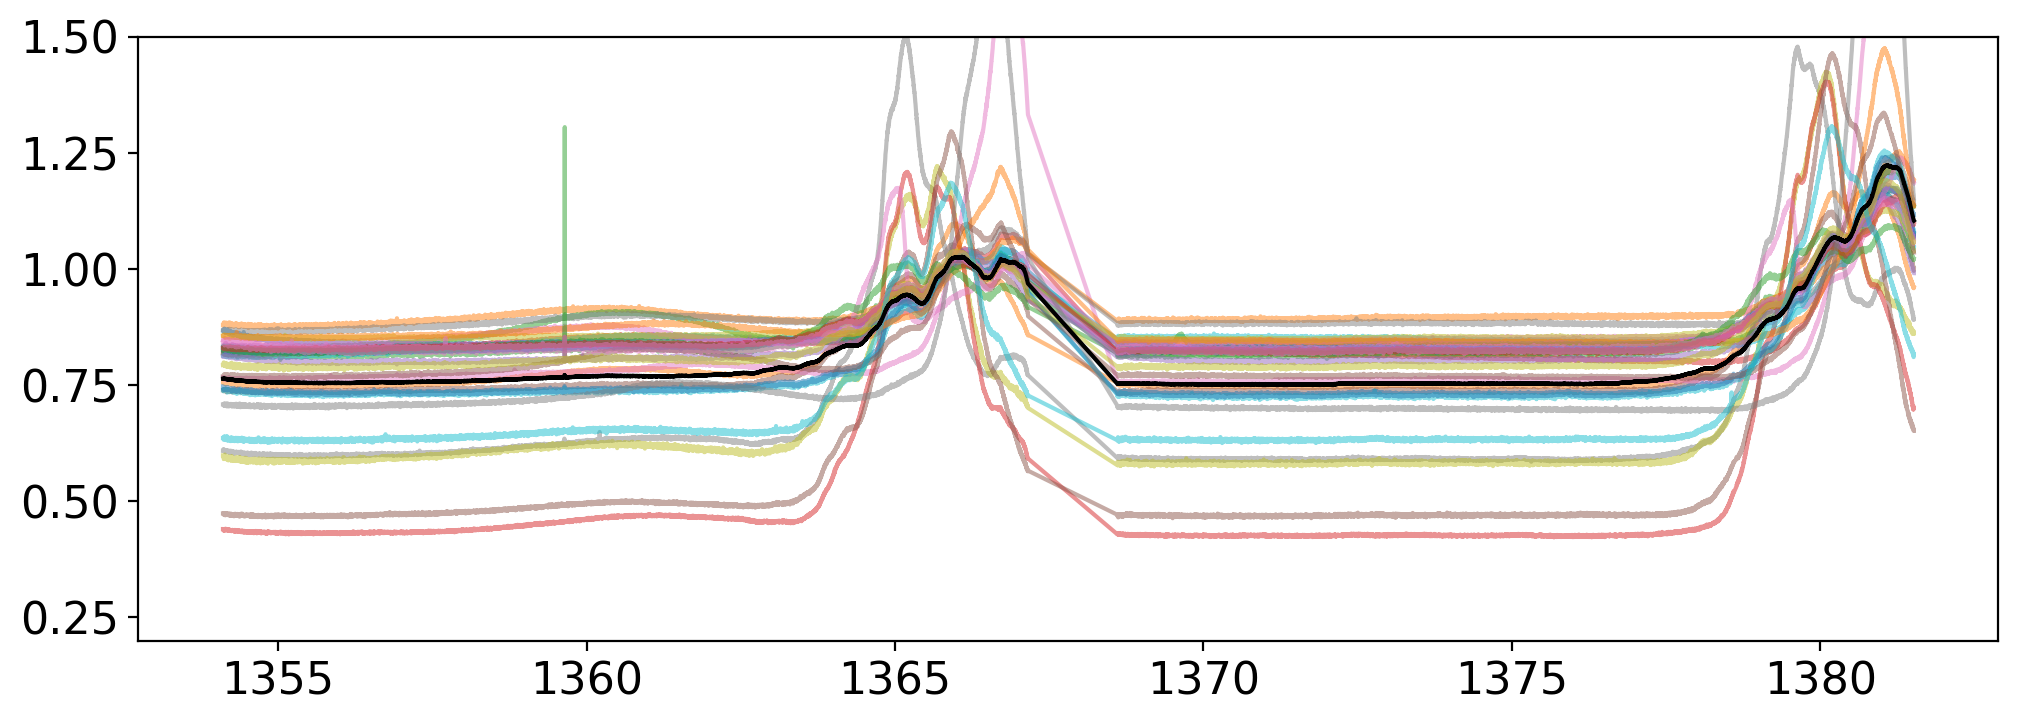

In [15]:
N = len(cameras)
for i in np.linspace(0,N-1,30):
    plt.plot(time, bkgs[int(i)]/np.nanpercentile(bkgs[int(i)], 90), alpha=0.5)
plt.plot(time, bkg/np.nanpercentile(bkg, 90), c='k')
plt.ylim([0.2,1.5]);
#plt.xlim([1363,1366.5]);

Per CCD:

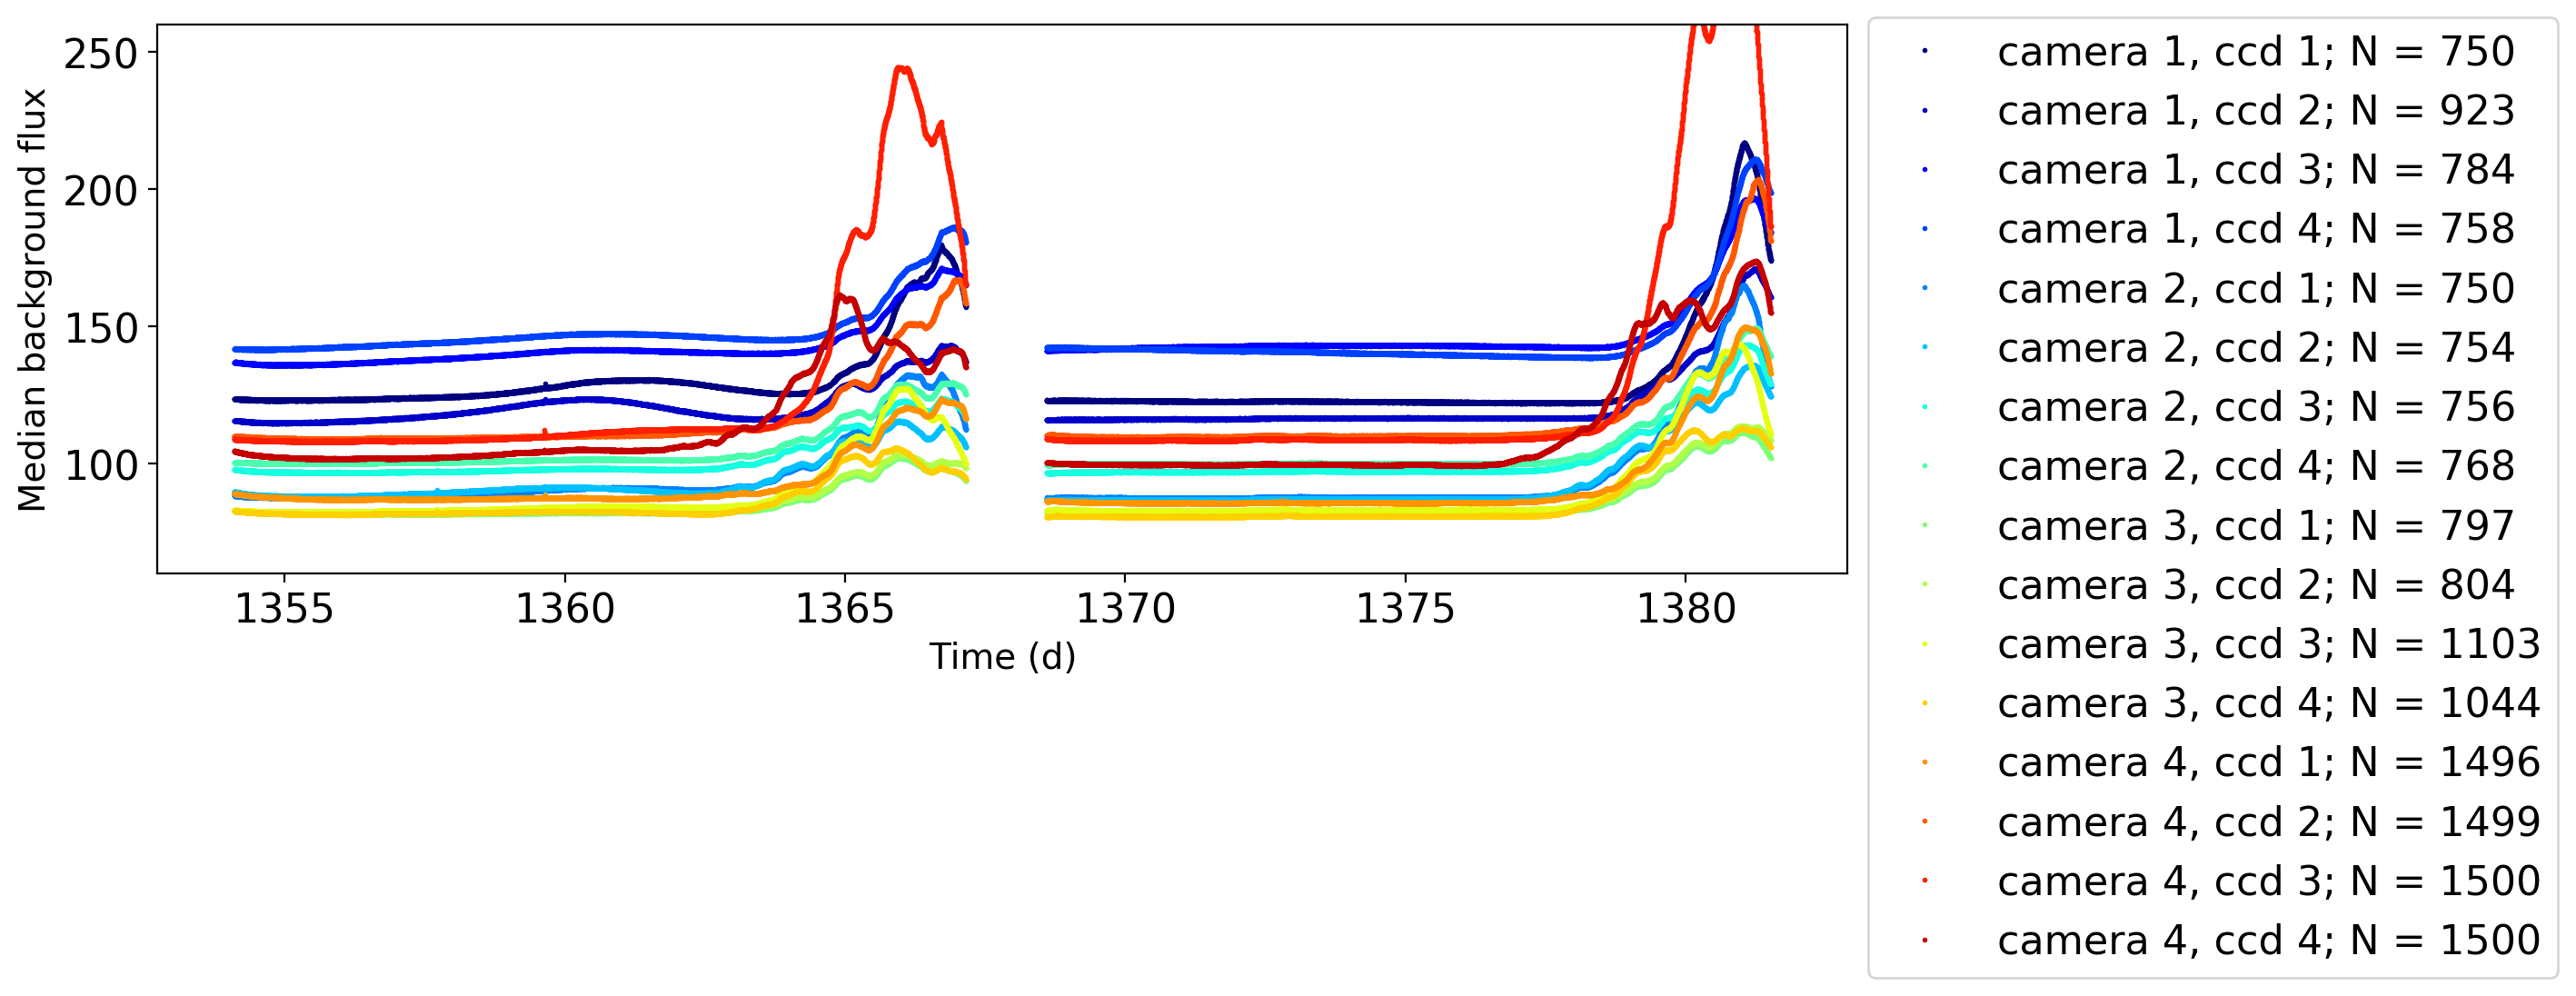

In [16]:
cm = plt.get_cmap('jet')
i = 0
for cam in range(1,5):
    for chip in range(1,5):
        mask = (cameras == cam) & (ccds == chip)
        plt.plot(time, np.nanmedian(bkgs[mask], axis=0),
                 label='camera {0}, ccd {1}; N = {2}'.format(cam,chip,np.sum(mask)), ms=1,
                 marker='o', ls='', c=cm(1.*i/16))
        i += 1
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.ylim([60,260])
plt.xlabel('Time (d)', fontsize=14)
plt.ylabel('Median background flux', fontsize=14);

Within a CCD:

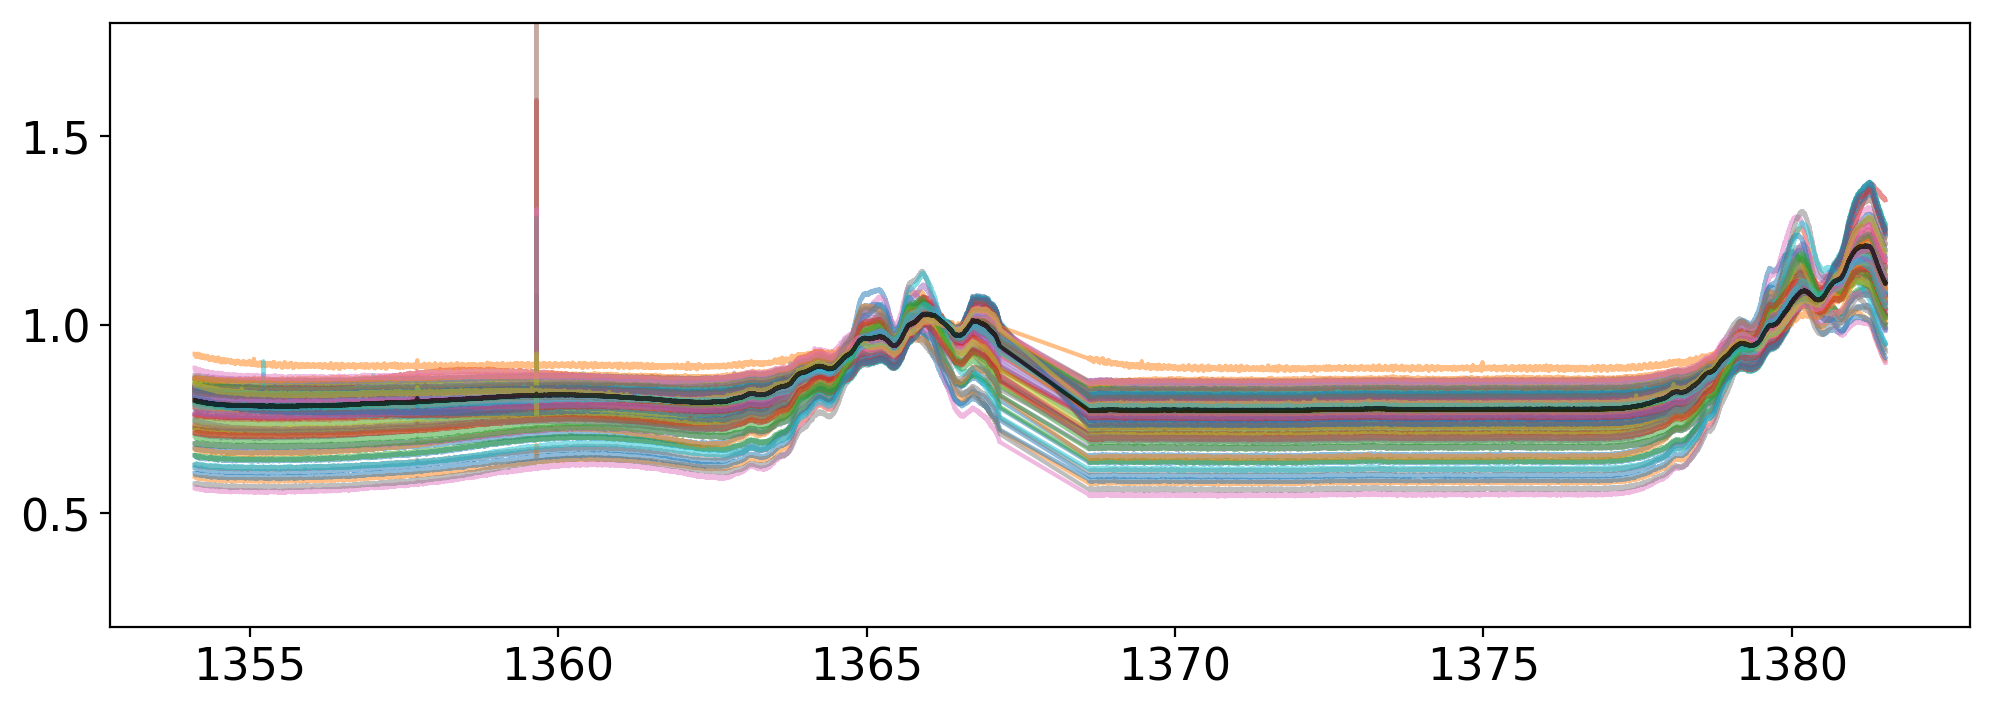

In [17]:
mask = (cameras == 2) & (ccds == 2)
inds = np.where(mask)[0]
for i in np.random.choice(inds, size=100, replace=False):
    plt.plot(time, bkgs[i]/np.nanpercentile(bkgs[i], 90), alpha=0.5)
bkg = np.nanmedian(bkgs[mask], axis=0)
plt.plot(time, bkg/np.nanpercentile(bkg, 90), c='k', alpha=0.7)
plt.ylim([0.2,1.8]);

### Categorize by features:
Get rid of wonky lightcurves (e.g. ones with diffraction regions) by sorting them into one or more categories of characteristic lightcurve shapes + outliers. Save only the characteristic LCs for analysis.

In [33]:
# approximate normalization:
rngs = np.empty(N)
snrs = np.empty(N)
fnorm = np.empty_like(bkgs)
for i,b in enumerate(bkgs):
    maxf = np.nanpercentile(b, 90)
    minf = np.nanpercentile(b, 10)
    rngs[i] = maxf - minf
    snrs[i] = np.nanmedian(b)/np.nanmedian(bkg_errs[i]) # SNR-ish
    fnorm[i] = (b - minf) / (maxf - minf)

In [34]:
ngroups = 3
thresh = [1.0 for g in range(ngroups-1)]

In [35]:
group = np.zeros(N, dtype=int)
score = np.zeros(N, dtype=float) * np.nan
med = np.zeros((ngroups, len(time)), dtype=float) * np.nan # median lc per group
sig = np.zeros((ngroups, len(time)), dtype=float) * np.nan # spread of lcs within group

# Loop over groups
for g in tqdm(range(ngroups - 1), total=ngroups - 1):
    # Compute the median absolute deviation of the group
    med[g] = np.nanmedian(fnorm[group==g], axis=0)
    mad = np.nanmedian(np.abs(fnorm[group==g] - med[g]), axis=0)
    sig[g] = 1.4826 * mad

    # Compute reduced chi^2 "score"
    for i in range(N):
        if group[i] == g:
            score[i] = np.nansum((fnorm[i] - med[g]) ** 2 / sig[g] ** 2) / len(time)

    # Remove the outlier light curves from this group
    group[score > thresh[g]] = g + 1

100%|██████████| 2/2 [00:25<00:00, 14.23s/it]


In [36]:
for g in range(ngroups):
    print(len(fnorm[group==g]))

7483
3810
4693


In [37]:
# Sort the light curves by range, highest to lowest
inds = np.argsort(rngs)[::-1]
#inds = np.arange(len(rngs))
flux = bkgs[inds[:2000]]
flux_err = bkg_errs[inds[:2000]]
fnorm = fnorm[inds[:2000]]
group = group[inds[:2000]]
score = score[inds[:2000]]

In [38]:
for g in range(ngroups):
    print(len(fnorm[group==g]))

1121
435
444


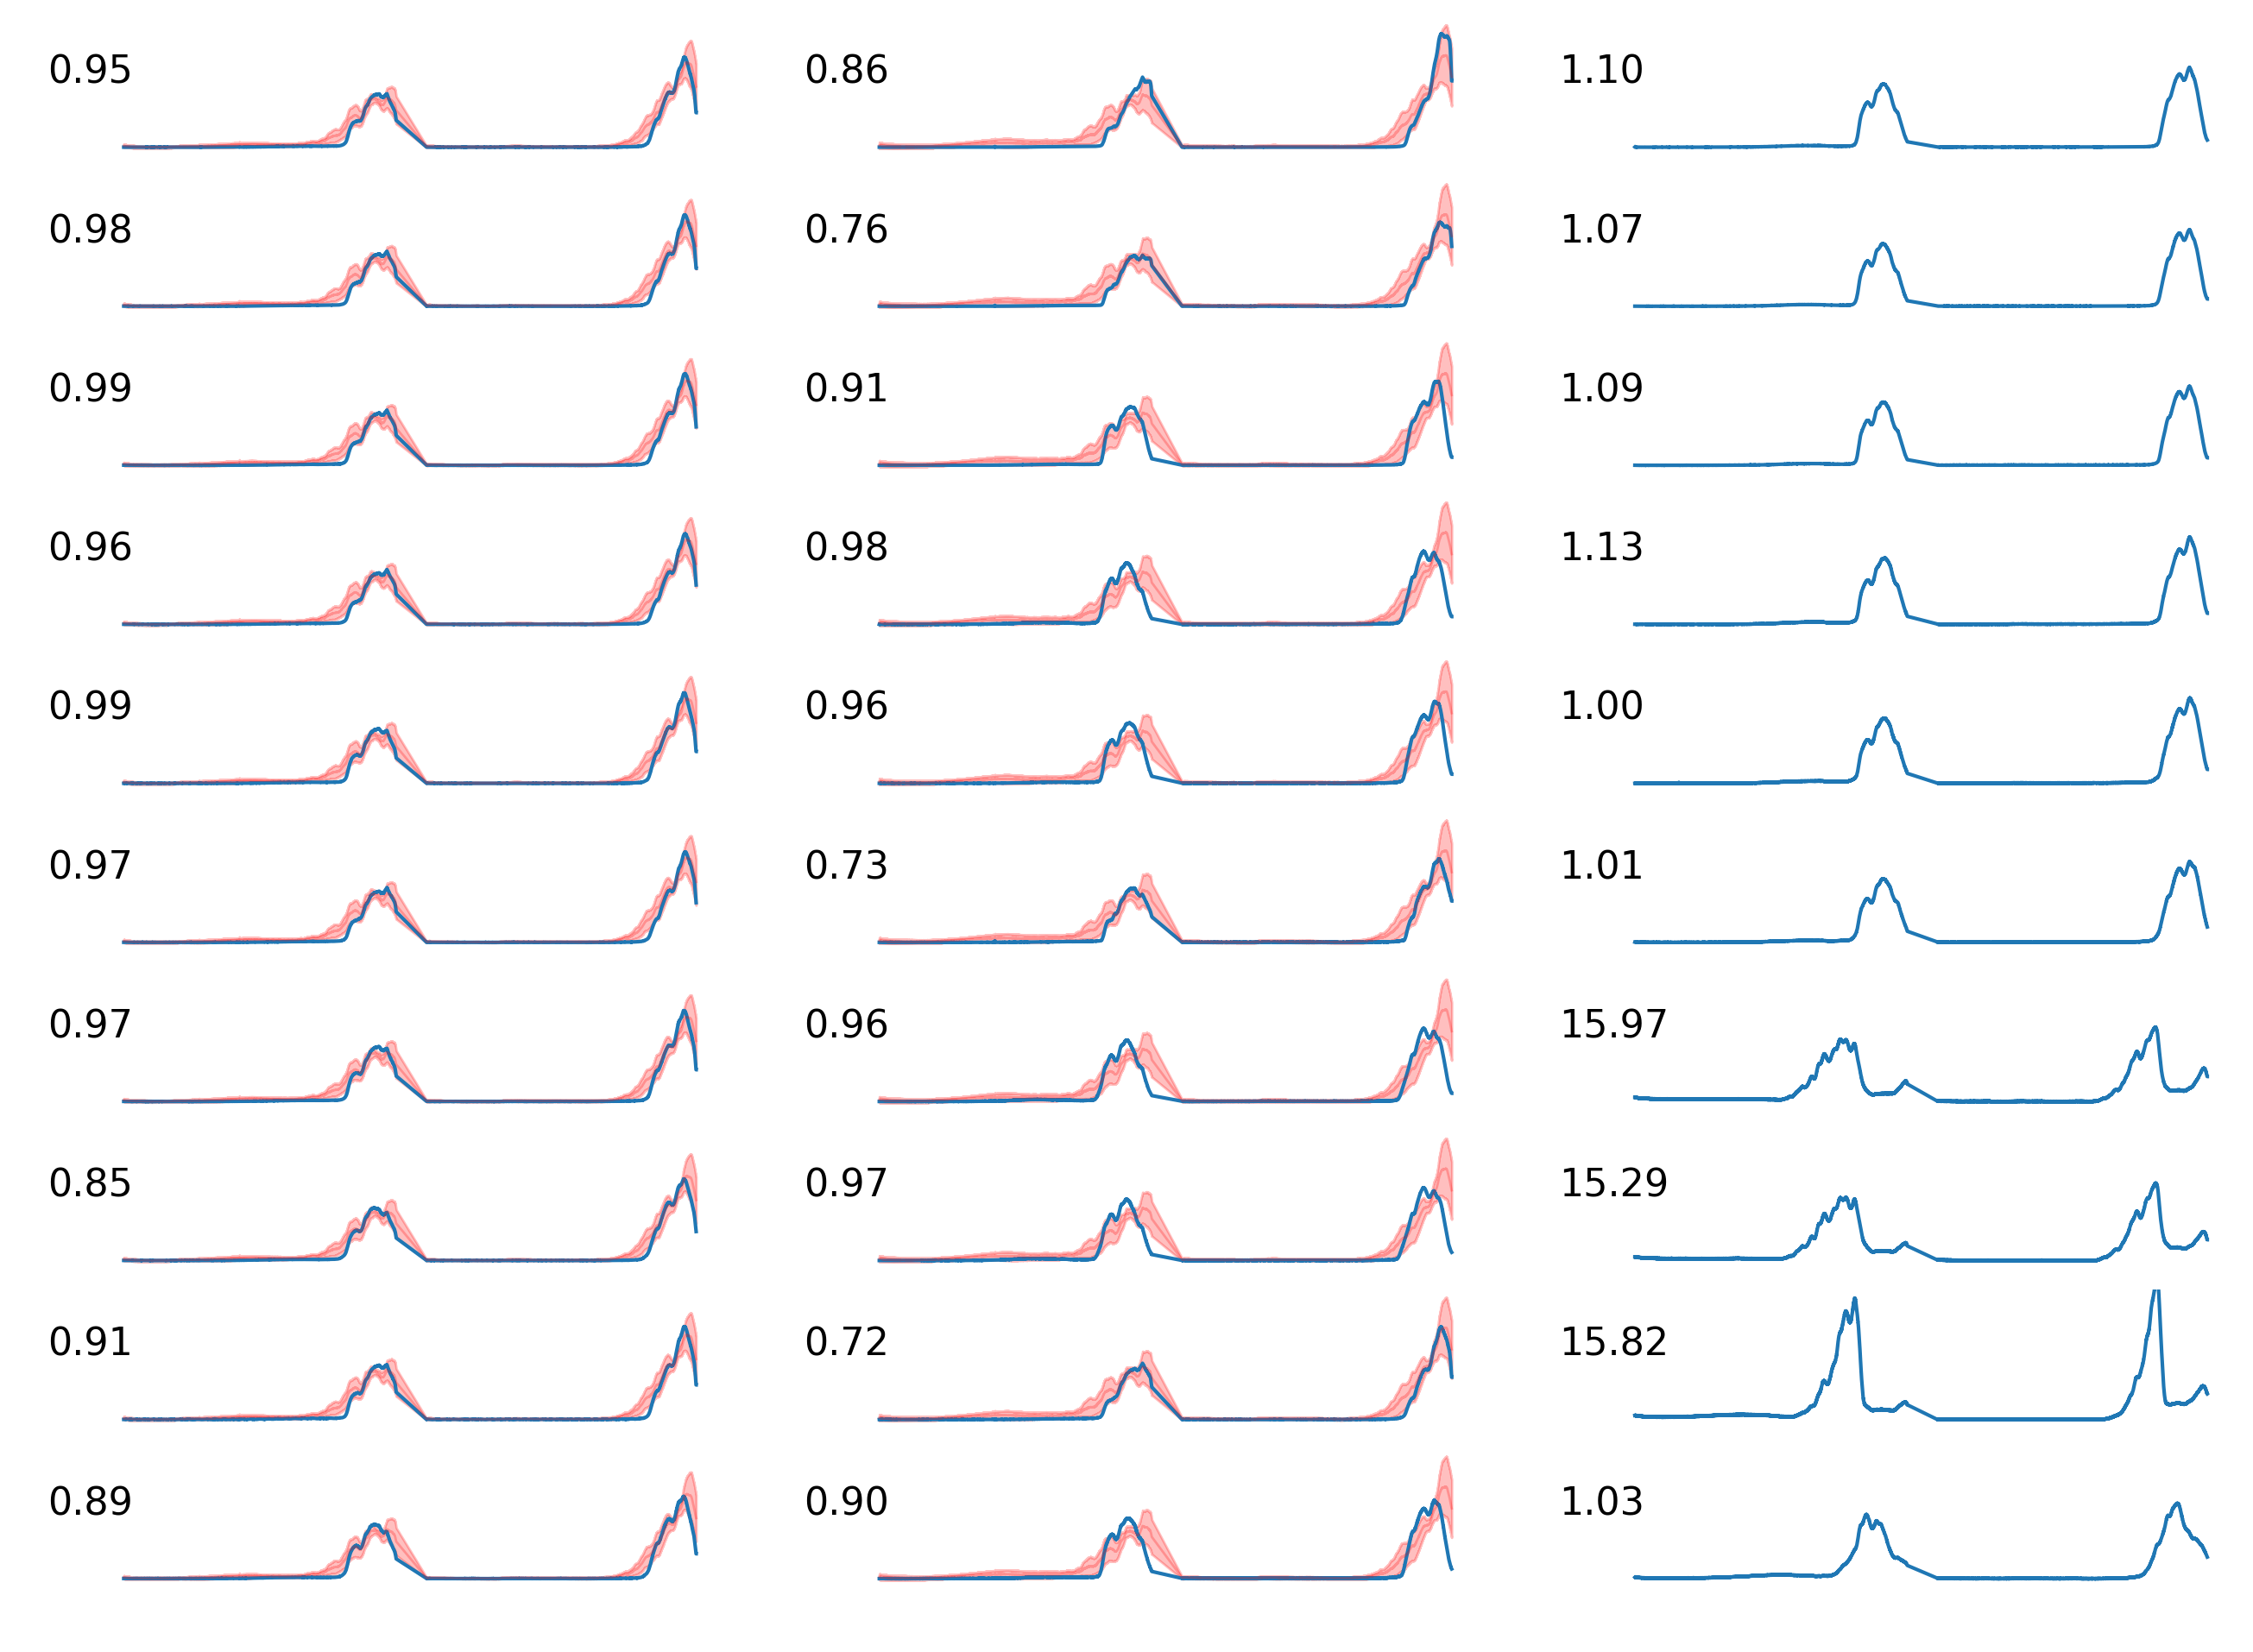

In [39]:
# Plot the first several
nrows = 10
fig, ax = plt.subplots(nrows, ngroups, figsize=(16, 12))
lo = np.nanmin(med[0] - 2 * sig[0])
hi = np.nanmax(med[0] + 2 * sig[0])
for g in range(ngroups):
    for n in range(nrows):
        if n < len(fnorm[group==g]):
            ax[n, g].plot(time, fnorm[group==g][n])
            ax[n, g].plot(time, med[g], "r-", lw=1, alpha=0.25)
            ax[n, g].fill_between(time, med[g] - sig[g], med[g] + sig[g], color="r", alpha=0.25)
            if np.isfinite(score[group==g][n]):
                ax[n, g].annotate("%.2f" % score[group==g][n], xy=(-0.075, 0.5), xycoords="axes fraction")
        ax[n, g].axis('off')
        ax[n, g].set_ylim(lo, hi)

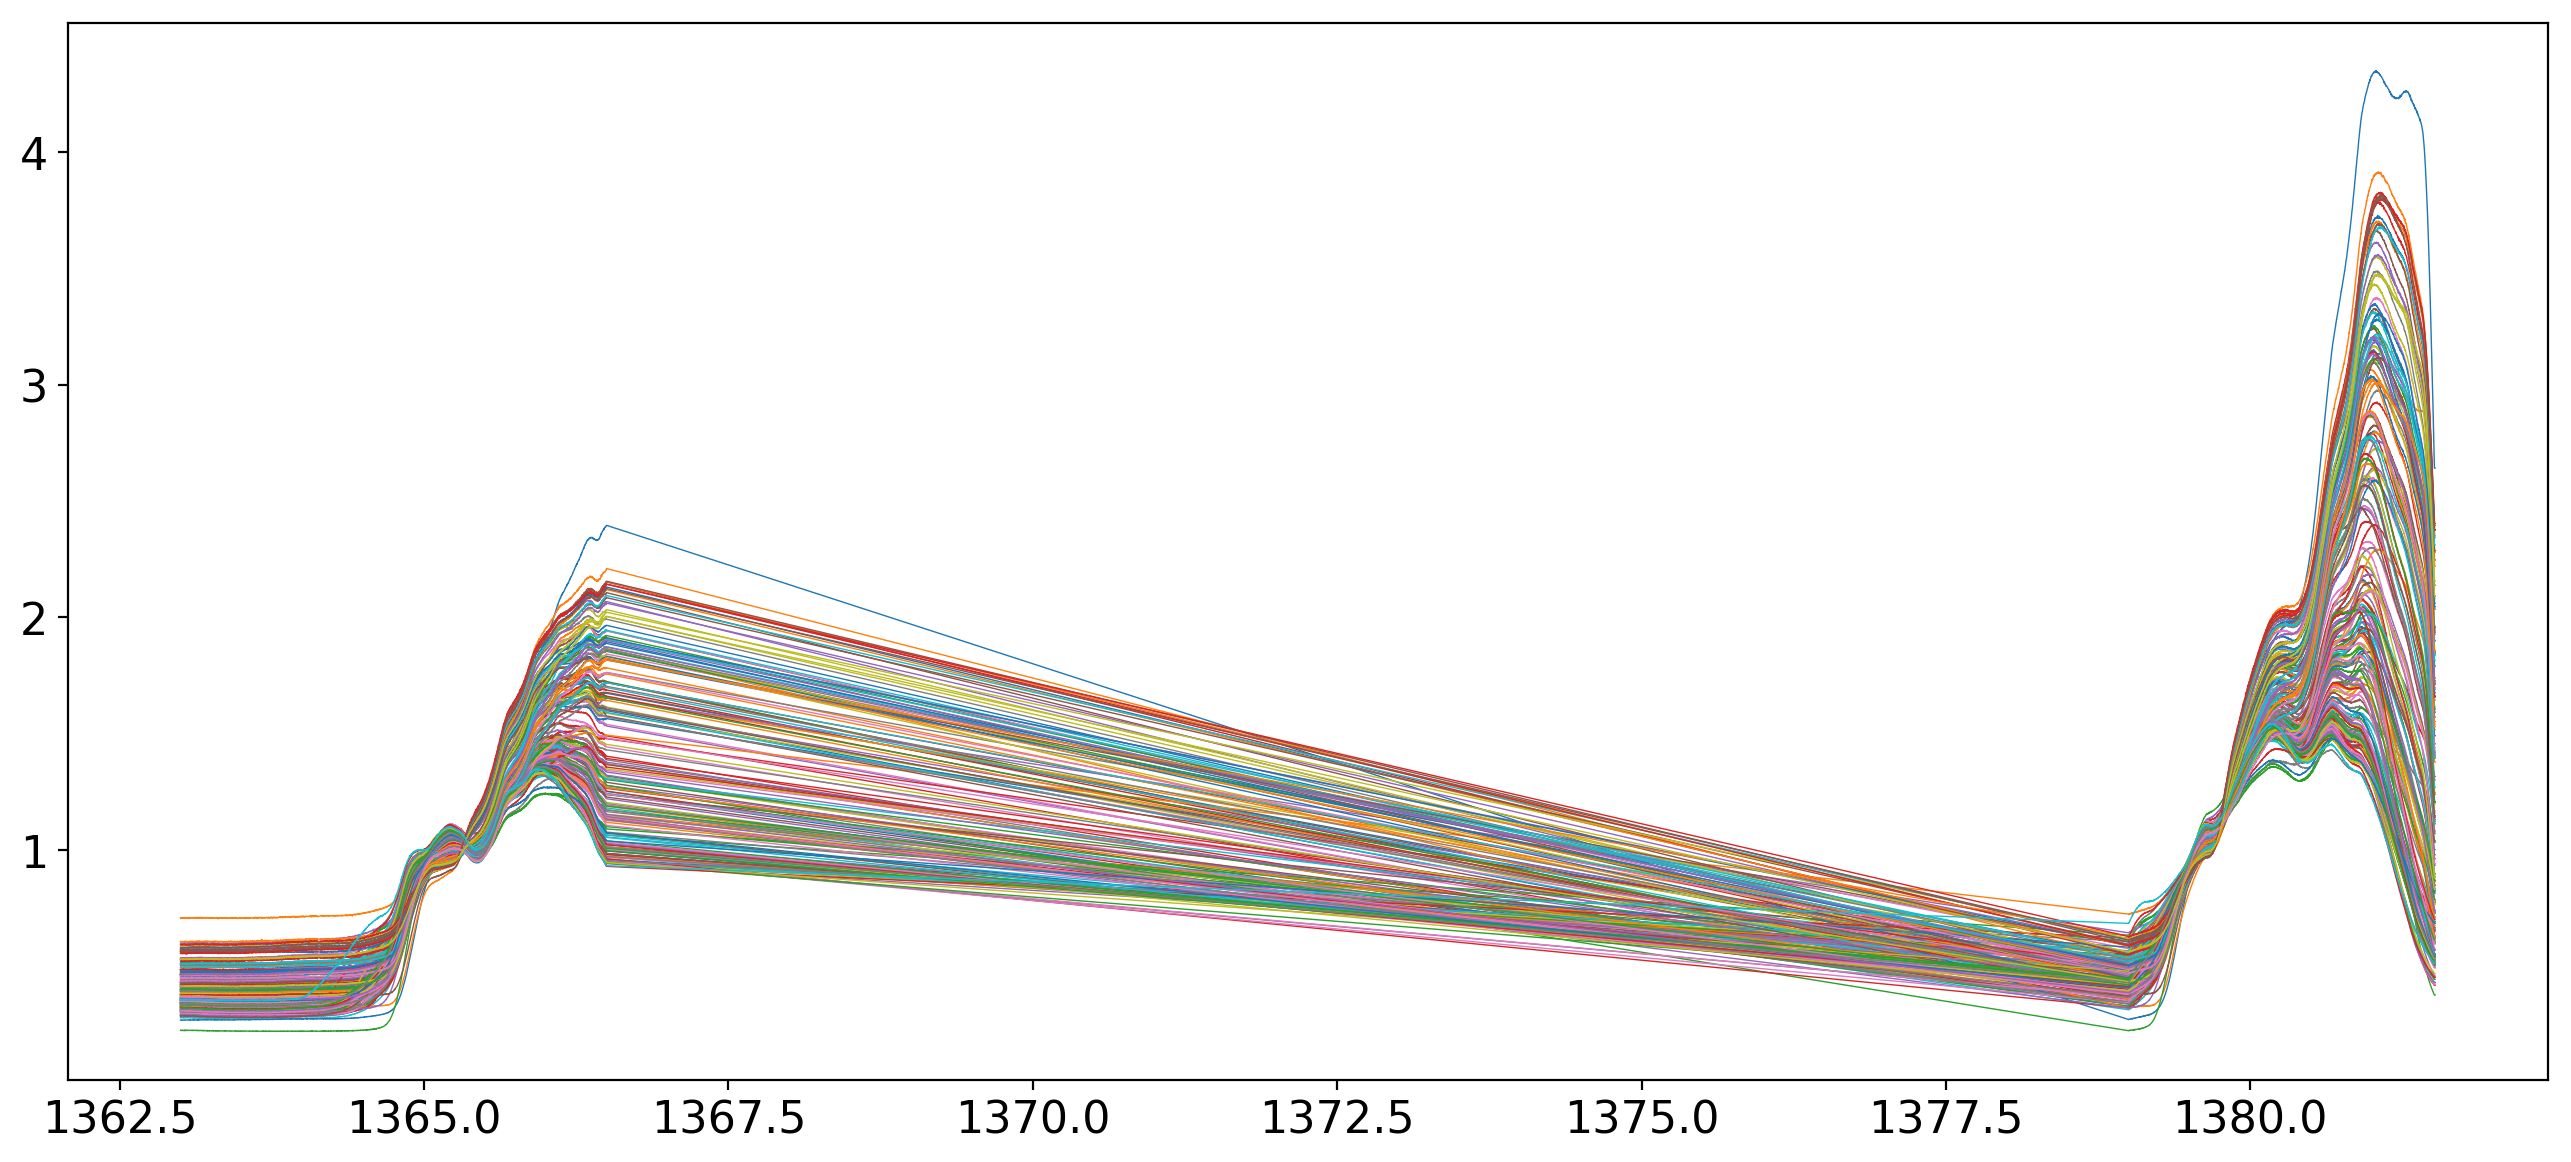

In [42]:
# Mask indices where Earth is not in view (~eyeballed)
earth_in_view = "((time > 1363.0) & (time < 1366.5)) | ((time > 1379) & (time < 1382))"
inds = eval(earth_in_view)

# Keep only the first few in each group
nreg_per_group = 100
times = time[inds]
fluxes = np.empty((nreg_per_group * (ngroups - 1), len(times)))
flux_errs = np.empty((nreg_per_group * (ngroups - 1), len(times)))
i = 0
for g in range(ngroups - 1):
    for n in range(nreg_per_group):
        fluxes[i] = flux[group==g][n][inds]
        norm = np.nanmedian(fluxes[i])
        fluxes[i] /= norm
        flux_errs[i] = flux_err[group==g][n][inds] / norm
        i += 1
        
# Plot our data
fig, ax = plt.subplots(1, figsize=(16, 7))
for f in fluxes:
    plt.plot(times, f, lw=0.5)

In [43]:
# Save the data
np.savez(data_dir+"sector{0:02.0f}-data.npz".format(sector), time=times, flux=fluxes, flux_err=flux_errs)